# Predicting accurate patient-specific voltages during direct electrocortical stimulation in vivo with finite element models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import uncertainpy as un
import os
import scipy.io as sio
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
import statsmodels.formula.api as smf
from matplotlib import cm
from collections import OrderedDict
from scipy import stats
import scikit_posthocs as sp
import matplotlib.colors as mcolors
import pingouin as pg

%matplotlib inline
pd.set_option('display.max_rows', None)
sns.set_context("paper", font_scale=3, rc={"font.size":10,"axes.labelsize":10})

/Users/chantel/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/chantel/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.7, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


## Import Data

In [2]:
# import subject data
plot_dict = pickle.load( open( "subject_data.pkl", "rb" ) )

## Plotting Functions

In [4]:
########## Plotting Functions #############
def set_plot_params():
    sns.set_style("whitegrid")
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    sns.set_context("paper", font_scale=10/8.8, rc={"font.size":10,"axes.labelsize":10})
    plt.rcParams.update({'text.color' : "black", 'axes.labelcolor' : "black", \
                         'xtick.color':"black", 'ytick.color':"black"})
    
    
def create_color_map(rigid=True, zeros=False, spacing=False):
    if rigid:
        maps = ['Greys_r','Reds_r','Greens_r','Blues_r']
    elif spacing:
        maps = ['Reds_r','Greys_r','Greens_r','Greys_r','Blues_r']
    else:
        maps = ['Reds_r','Greens_r','Blues_r']
    newcmap = np.empty([0,4])
    for cmap in maps:
        if cmap == 'Greys_r':
            cmap = cm.get_cmap(cmap,100)
            newcmap = np.append(newcmap, cmap(np.linspace(.5,.5,1)), axis=0)
        else:
            cmap = cm.get_cmap(cmap,100)
            if zeros:
                newcmap = np.append(newcmap, cmap(np.linspace(.2,.8,1)), axis=0)
            else:
                newcmap = np.append(newcmap, cmap(np.linspace(.2,.8,3)), axis=0)
    return newcmap

    
########## Dataframe Functions #############
def make_projection_dist_dataframe(subject_dict):
    projection_dist = []
    mesh_type = []
    if subject_dict['name'] in ['subject_1', 'subject_2', 'subject_3', 'subject_4']:
        proj_methods = ['principal_axis','hermes','dykstra']
    else:
        proj_methods = ['principal_axis','hermes']
    for proj_method in proj_methods:
        for i in range(3):
            csf = str(i)
            mesh_type = mesh_type + [proj_method + '_' + csf for i in range(len(subject_dict['proj_dist_' + proj_method + '_' + csf]))]
            projection_dist.extend(subject_dict['proj_dist_' + proj_method + '_' + csf])
    d = {'mesh_type':mesh_type, 'projection_dist':projection_dist}
    df=pd.DataFrame(data=d)
    return df

def make_interelectrode_dataframe(subject_dict):
    interelectrode_dist = []
    mesh_type = []
    if subject_dict['name'] in ['subject_1', 'subject_2', 'subject_3', 'subject_4']:
        proj_methods = ['principal_axis','hermes','dykstra']
    else:
        proj_methods = ['principal_axis','hermes']
    for proj_method in proj_methods:
        for i in range(3):
            csf = str(i)
            mesh_type = mesh_type + [proj_method + '_' + csf for i in range(len(subject_dict['interelectrode_dist_' + proj_method + '_' + csf]))]
            interelectrode_dist.extend(subject_dict['interelectrode_dist_' + proj_method + '_' + csf])
    mesh_type = mesh_type + ['original' for i in range(len(subject_dict['interelectrode_dist_orig']))]
    interelectrode_dist.extend(subject_dict['interelectrode_dist_orig'])
    if subject_dict['name'] != 'subject_5':
        mesh_type = mesh_type + ['rigid' for i in range(len(subject_dict['interelectrode_dist_rigid']))]
        interelectrode_dist.extend(subject_dict['interelectrode_dist_rigid'])
    d = {'mesh_type':mesh_type, 'interelectrode_dist':interelectrode_dist}
    df=pd.DataFrame(data=d)
    return df


def make_voltage_dataframe(subject_dict):
    voltage = subject_dict['clinical_voltage']
    electrode_num = [i+1 for i in range(len(subject_dict['clinical_voltage']))]
    voltage_type = ['clinical' for i in range(len(subject_dict['clinical_voltage']))]
    if subject_dict['name'] != 'subject_5':
        electrode_num = electrode_num + [i+1 for i in range(len(subject_dict['clinical_voltage']))]
        voltage_type = voltage_type + ['rigid' for i in range(len(subject_dict['clinical_voltage']))]
        voltage = np.concatenate((voltage, subject_dict['voltage_sol_rigid'][0,:len(subject_dict['clinical_voltage'])]),axis=None)
    if subject_dict['name'] in ['subject_1', 'subject_2', 'subject_3', 'subject_4']:
        proj_methods = ['principal_axis','hermes','dykstra']
    else:
        proj_methods = ['principal_axis','hermes']
    for proj_method in proj_methods:
        for i in range(3):
            csf = str(i)
            voltage = np.concatenate((voltage, subject_dict['voltage_sol_' + proj_method + '_' + csf][0,:len(subject_dict['clinical_voltage'])]),axis=None)
            electrode_num = electrode_num + [j+1 for j in range(len(subject_dict['clinical_voltage']))]
            voltage_type = voltage_type + [proj_method + '_' + csf for i in range(len(subject_dict['clinical_voltage']))]
    voltage = voltage*1000
    d = {'voltage':voltage, 'voltage_type':voltage_type, 'electrode_number': electrode_num}
    df=pd.DataFrame(data=d)
    return df


def create_voltage_df(plot_dict):
    subject_list = [subject for subject,v in plot_dict.items() \
                    for i in range(len(plot_dict[subject]['clinical_voltage']))]
    electrode = [i for subject,v in plot_dict.items() for i in range(len(plot_dict[subject]['clinical_voltage']))]
    stim_amp = [plot_dict[subject]['stim_amplitude'][0] for subject,v in plot_dict.items() \
                    for i in range(len(plot_dict[subject]['clinical_voltage']))]
    clinical = [i*1000 for subject,v in plot_dict.items() for i in plot_dict[subject]['clinical_voltage']]
    rigid = [i*1000 for subject,v in plot_dict.items() \
             for i in plot_dict[subject]['voltage_sol_rigid'][0][:len(plot_dict[subject]['clinical_voltage'])]]
    principal_axis_0 = [i*1000 for subject,v in plot_dict.items() \
             for i in plot_dict[subject]['voltage_sol_principal_axis_0'][0][:len(plot_dict[subject]['clinical_voltage'])]]
    principal_axis_1 = [i*1000 for subject,v in plot_dict.items() \
             for i in plot_dict[subject]['voltage_sol_principal_axis_1'][0][:len(plot_dict[subject]['clinical_voltage'])]]
    principal_axis_2 = [i*1000 for subject,v in plot_dict.items() \
             for i in plot_dict[subject]['voltage_sol_principal_axis_2'][0][:len(plot_dict[subject]['clinical_voltage'])]]
    hermes_0 = [i*1000 for subject,v in plot_dict.items() \
             for i in plot_dict[subject]['voltage_sol_hermes_0'][0][:len(plot_dict[subject]['clinical_voltage'])]]
    hermes_1 = [i*1000 for subject,v in plot_dict.items() \
             for i in plot_dict[subject]['voltage_sol_hermes_1'][0][:len(plot_dict[subject]['clinical_voltage'])]]
    hermes_2 = [i*1000 for subject,v in plot_dict.items() \
             for i in plot_dict[subject]['voltage_sol_hermes_2'][0][:len(plot_dict[subject]['clinical_voltage'])]]

    dykstra_0 = []
    for subject,v in plot_dict.items():
        if 'voltage_sol_dykstra_0' in plot_dict[subject].keys():
            for i in plot_dict[subject]['voltage_sol_dykstra_0'][0][:len(plot_dict[subject]['clinical_voltage'])]:
                dykstra_0.append(i*1000)
        else:
            for i in plot_dict[subject]['voltage_sol_hermes_0'][0][:len(plot_dict[subject]['clinical_voltage'])]:
                dykstra_0.append(None)
    dykstra_1 = []
    for subject,v in plot_dict.items():
        if 'voltage_sol_dykstra_1' in plot_dict[subject].keys():
            for i in plot_dict[subject]['voltage_sol_dykstra_1'][0][:len(plot_dict[subject]['clinical_voltage'])]:
                dykstra_1.append(i*1000)
        else:
            for i in plot_dict[subject]['voltage_sol_hermes_0'][0][:len(plot_dict[subject]['clinical_voltage'])]:
                dykstra_1.append(None)
    dykstra_2 = []
    for subject,v in plot_dict.items():
        if 'voltage_sol_dykstra_2' in plot_dict[subject].keys():
            for i in plot_dict[subject]['voltage_sol_dykstra_2'][0][:len(plot_dict[subject]['clinical_voltage'])]:
                dykstra_2.append(i*1000)
        else:
            for i in plot_dict[subject]['voltage_sol_hermes_0'][0][:len(plot_dict[subject]['clinical_voltage'])]:
                dykstra_2.append(None)
    data = {'subject':subject_list, 'stim_amp':stim_amp, 'electrode':electrode, 'clinical':clinical, 'rigid':rigid,
            'principal_axis_0':principal_axis_0, 'principal_axis_1':principal_axis_1, 'principal_axis_2':principal_axis_2,
           'hermes_0':hermes_0, 'hermes_1':hermes_1,'hermes_2':hermes_2,
           'dykstra_0':dykstra_0, 'dykstra_1':dykstra_1,'dykstra_2':dykstra_2}

    df = pd.DataFrame(data)
    return df


def log_absolute_error(df):
    df = df.copy(deep=True)
    for col in df.columns:
        if any(string in col for string in ['error','subject','electrode','clinical','stim_amp']):
            pass
        else:
            df['error_'+col] = np.log10(np.absolute(np.subtract(df[col], df['clinical'])))
            df['error_'+col][df['error_'+col] < -1] = -1
    return df 


########## Statistics Functions #############
def compare_projection(df):
    for subject in ['subject_' + str(i + 1) for i in range(6)]:
        # check if variance is different
        hermes = df[df["mesh_type"]==subject+'hermes_0']['projection_dist']
        principal_axis = df[df["mesh_type"]==subject+'principal_axis_0']['projection_dist']
        stat, p = stats.levene(hermes, principal_axis,center='median')
        print(f"{subject} principal axis vs hermes projection levene p_value = {p}")
        stat, p = stats.wilcoxon(hermes, principal_axis)
        print(f"{subject} principal axis vs hermes projection wilcoxan p_value = {p}")
        stat, p = stats.ttest_rel(hermes, principal_axis)
        print(f"{subject} principal axis vs hermes projection ttest p_value = {p}")
    return 

def compare_interelectrode(df):
    for subject in ['subject_' + str(i + 1) for i in range(6)]:
        hermes = df[df["mesh_type"]==subject+'hermes_0']['interelectrode_dist']
        principal_axis = df[df["mesh_type"]==subject+'principal_axis_0']['interelectrode_dist']
        # check if variance is different
        stat, p = stats.levene(hermes, principal_axis,center='median')
        print(f"{subject} principal axis vs hermes interelectrode levene p_value = {p}")
        stat, p = stats.wilcoxon(hermes, principal_axis)
        print(f"{subject} principal axis vs hermes projection wilcoxan p_value = {p}")
    return 

########## Figure Functions #############

# Figure 3A
def plot_projection_distance(subject_dict):
    set_plot_params()
    plt.figure(figsize=(15/3,4))
    
    # create color map
    # create color map
    maps = ['Reds_r','Greens_r']
    newcmap = np.empty([0,4])
    for cmap in maps:
        cmap = cm.get_cmap(cmap,100)
        newcmap = np.append(newcmap, cmap(np.linspace(.2,.8,1)), axis=0)
    newcmap = np.append(newcmap, cmap(np.linspace(.2,.8,1)), axis=0)
    
    # create dataframe
    df1 = pd.DataFrame()
    for i,subject in enumerate(['subject_' + str(i + 1) for i in range(6)]):
        df=make_projection_dist_dataframe(subject_dict[subject])
        df = df[df['mesh_type'].str.contains("principal_axis_0")]
        df.mesh_type.replace(['principal_axis_0'], [subject_dict[subject]['name']+'principal_axis_0'], inplace=True)
        df['x_label'] = [i*3 for j in range(len(df))]
        df1 = pd.concat([df1,df]) 
        df=make_projection_dist_dataframe(subject_dict[subject])
        df = df[df['mesh_type'].str.contains("hermes_0")]
        df.mesh_type.replace(['hermes_0'], [subject_dict[subject]['name']+'hermes_0'], inplace=True)
        df['x_label'] = [i*3+1 for j in range(len(df))]
        df1 = pd.concat([df1,df])
    
    df = pd.DataFrame([['hermes_0',x*3+2,None] for x in range(5)], columns=['mesh_type','x_label','projection_dist'])
    df1 = df1.append(df)
    
    #plotting
    sns.swarmplot(x="x_label",y="projection_dist", data=df1, palette=newcmap, size=1.5, alpha=.7)     
    sns.boxplot(x="x_label",y="projection_dist", data=df1, color='White', linewidth=2, width = .8, fliersize=3)  
    plt.ylim(0, 25)
    plt.yticks([0, 5, 10, 15, 20 ,25]) 
    plt.ylabel('Projection Distance, mm')
    plt.title(f"Figure 3A")   
    plt.xlabel(' ')
    
    # statistics
#     compare_projection(df1)
    return


# Figure 3B 
def plot_interelectrode_distance(subject_dict):
    set_plot_params()
    plt.figure(figsize=(15/3,4))

    # create color map
    maps = ['Reds_r','Greens_r']
    newcmap = np.empty([0,4])
    for cmap in maps:
        cmap = cm.get_cmap(cmap,100)
        newcmap = np.append(newcmap, cmap(np.linspace(.2,.8,1)), axis=0)
    newcmap = np.append(newcmap, cmap(np.linspace(.2,.8,1)), axis=0)
    
    # create dataframe
    df1 = pd.DataFrame()  
    # plot in order of least median projection distance
    for i,subject in enumerate(['subject_' + str(i + 1) for i in range(6)]):
        df=make_interelectrode_dataframe(subject_dict[subject])
        df = df[df['mesh_type'].str.contains("principal_axis_0")]
        df.mesh_type.replace(['principal_axis_0'], [subject_dict[subject]['name']+'principal_axis_0'], inplace=True)
        df['x_label'] = [i*3 for j in range(len(df))]
        df1 = pd.concat([df1,df]) 
        df=make_interelectrode_dataframe(subject_dict[subject])
        df = df[df['mesh_type'].str.contains("hermes_0")]
        df.mesh_type.replace(['hermes_0'], [subject_dict[subject]['name']+'hermes_0'], inplace=True)
        df['x_label'] = [i*3+1 for j in range(len(df))]
        df1 = pd.concat([df1,df])
    df = pd.DataFrame([['hermes_0',x*3+2,None] for x in range(5)], columns=['mesh_type','x_label','interelectrode_dist'])
    df1 = df1.append(df)
    df = df1
    #plotting
    sns.swarmplot(x="x_label", y="interelectrode_dist", data=df, palette=newcmap, size=1.5, alpha=.7)     
    sns.boxplot(x="x_label", y="interelectrode_dist", data=df, color="White", linewidth=2, width=.8, fliersize=3)   
    plt.ylabel('Interelectrode Distances, mm')
    plt.title(f"Figure 3C")
    plt.xlabel(' ')
    plt.ylim(0, 25)
    
    #statistics
#     compare_interelectrode(df)
    return


# Figure 3B & 3D
def plot_pairwise_distances(subject_dict):
    set_plot_params()
    plt.figure(figsize=(6/3,4))
    
    ########## Projection Distance #############
    # create dataframe
    df2 = pd.DataFrame() 
    for i,subject in enumerate(['subject_' + str(i + 1) for i in range(6)]):
        df=make_projection_dist_dataframe(subject_dict[subject])
        df = df[df['mesh_type'].str.contains("principal_axis_0")]
        df = df.reset_index()
        df1=make_projection_dist_dataframe(subject_dict[subject])
        df1 = df1[df1['mesh_type'].str.contains("hermes_0")]
        df1 = df1.reset_index()
        df3 = pd.DataFrame()
        df3['projection_dist'] = df['projection_dist']-df1['projection_dist']
        df3['x_label'] = [subject for j in range(len(df))]
        df2 = pd.concat([df2,df3])
    
    #plotting
    sns.swarmplot(x="x_label",y="projection_dist", data=df2, size=1.5, alpha=.7, color='Black')     
    sns.boxplot(x="x_label",y="projection_dist", data=df2, color='White', linewidth=2, width = .8, fliersize=3)  
    plt.ylim(-2, 5)
    plt.ylabel('Projection Distance Difference, mm')
    plt.xlabel('Patient')
    plt.title(f"Figure 3B")   

    ########## Interelectrode #############
    plt.figure(figsize=(6/3,4))
    set_plot_params()
    
    # create dataframe
    df2 = pd.DataFrame()  
    # plot in order of least median projection distance
    for i,subject in enumerate(['subject_' + str(i + 1) for i in range(6)]):
        df = make_interelectrode_dataframe(subject_dict[subject])
        df = df[df['mesh_type'].str.contains("principal_axis_0")]
        df = df.reset_index()
        df1 = make_interelectrode_dataframe(subject_dict[subject])
        df1 = df1[df1['mesh_type'].str.contains("hermes_0")]
        df1 = df1.reset_index()
        df3 = pd.DataFrame()
        df3['interelectrode_dist'] = df['interelectrode_dist']-df1['interelectrode_dist']
        df3['x_label'] = [subject for j in range(len(df))]
        df2 = pd.concat([df2,df3])

    #plotting
    sns.swarmplot(x="x_label", y="interelectrode_dist", data=df2, color="Black", size=1.5, alpha=.7)     
    sns.boxplot(x="x_label", y="interelectrode_dist", data=df2, color="White", linewidth=2, width=.8, fliersize=3)   
    plt.xlabel('Patient')
    plt.ylabel('Interelectrode Distance Difference, mm')
    plt.title(f"Figure 3D")
    plt.ylim(-6, 10)
    return
    
    
# Figure 4C
def plot_final_voltage_subject(subject_dict, projection_method):
    set_plot_params()
    plt.figure(figsize=(16,5))
    
    # create color map
    if 'hermes' in projection_method:
        map_proj = 'Greens_r'
    elif 'dykstra' in projection_method:
        map_proj = 'Blues_r'
    else:
        map_proj = 'Reds_r'
    maps = ['Greys_r',map_proj,'hsv_r']
    newcmap = np.empty([0,4])
    for cmap in maps:
        cmap = cm.get_cmap(cmap,100)
        newcmap = np.append(newcmap, cmap(np.linspace(.2,.8,1)), axis=0)
        
    df = make_voltage_dataframe(subject_dict)
    df1 = df[df['voltage_type'].str.contains('rigid')].reset_index(drop=True)
    df2 = df[df['voltage_type'].str.contains(projection_method)].reset_index(drop=True)
    df3 = df[df['voltage_type'].str.contains("clinical")].reset_index(drop=True)
    df = pd.DataFrame()
    
    # create gaps in between rows of the grid for subject 3
    for df4 in [df1, df2, df3]:
        for elec_num in [8.5, 16.5, 24.5, 32.4, 40.5, 48.5, 56.5]:
            new_row = {'electrode_number':elec_num, 'voltage':None, 'voltage_type':df4['voltage_type'][0]}
            df4 = df4.append(new_row, ignore_index=True)
        df4 = df4.sort_values(by='electrode_number')
        df = pd.concat([df,df4])
    df = df.reset_index(drop=True)
    
    # plotting
    voltages = ['rigid', projection_method, 'clinical']
    for i,group in enumerate(voltages):
        plt.plot('electrode_number', 'voltage', data = df[df['voltage_type'] == group], alpha=0.8, marker='o', color = newcmap[i])
    plt.xlabel('Electrode Number')
    plt.ylabel('Voltage, mV')
    plt.title(f"Figure 4C")
    plt.xlim(0, 65)
    plt.ylim(-40,100)
    return


# Figure 4D
def plot_error_all_methods_subject(df, subject, rigid=True, error_type='Relative'):
    mask = df['subject'] == subject
    df = df[mask] 
    set_plot_params()
    plt.figure(figsize=(16/10*11/2.5,5/2.5))
    df = df.copy(deep=True)
    df = df.loc[:,df.columns.str.contains("error")]
    if not rigid:
        df = df.drop(df.loc[:,df.columns.str.contains("rigid")], 1)
    df.reset_index(inplace = True, drop = True)
    
    newcmap = create_color_map(rigid)
    
    b=sns.violinplot(data=df, saturation=1, palette=newcmap, linewidth=1.2, width=1, cut=0, inner='quartile')       
    b.tick_params(labelsize=10)
    b.set_xticklabels(['' for i in range(len(df.columns))])
    if error_type == 'Absolute':
        b.set_ylabel(f"{error_type} Error, mV",fontsize=10)
    else:
        b.set_ylabel(f"{error_type} Error",fontsize=10)
    plt.title(f"Figure 4D")
    plt.ylim([np.log10(.1),np.log10(100)])
    labels = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60,
              70, 80, 90, 100]
    new_labels = [.1, '', '', '', '', '', '', '', '',1, '', '', '', '', '', '', '', '', 10, 
                  '', '', '', '', '', '', '', '', 100]
    plt.yticks(np.log10(labels), new_labels);
    return

# Figure 5A
def plot_error_all_methods(df, rigid=True, error_type='Relative'):
    
    set_plot_params()
    plt.figure(figsize=(16/10*11/2.5,5/2.5))
    df = df.copy(deep=True)
    df = df.loc[:,df.columns.str.contains("error")]
    if not rigid:
        df = df.drop(df.loc[:,df.columns.str.contains("rigid")], 1)
    df.reset_index(inplace = True, drop = True)
    df.insert(loc=3, column='blank_0', value=[None for i in range(len(df.iloc[:,0]))])
    df.insert(loc=7, column='blank_1', value=[None for i in range(len(df.iloc[:,0]))])
    newcmap = create_color_map(rigid=rigid, spacing=True)
    
    b=sns.violinplot(data=df, saturation=1, palette=newcmap, linewidth=1, width=1, cut=0, inner='quartile')       
    b.tick_params(labelsize=10)
    b.set_xticklabels(['' for i in range(len(df.columns))])
    if error_type == 'Absolute':
        b.set_ylabel(f"{error_type} Error, mV",fontsize=10)
    else:
        b.set_ylabel(f"{error_type} Error",fontsize=10)
    plt.title(f"Figure 5A")
    plt.ylim([np.log10(.1),np.log10(100)]);
    labels = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60,
              70, 80, 90, 100];
    new_labels = [.1, '', '', '', '', '', '', '', '',1, '', '', '', '', '', '', '', '', 10, 
                  '', '', '', '', '', '', '', '', 100];
    plt.yticks(np.log10(labels), new_labels);
    return

# Figure 5B
def plot_predicted_vs_clinical_all(df):
    df_normalized = df.copy(deep=True)
    
    set_plot_params(); 
    
    # normalize voltages by stimulation amplitude
    df_normalized['clinical'] = df_normalized['clinical']/df_normalized['stim_amp']
    slopes = []
    cis = []
    residuals = {}
    for col in df_normalized.columns:
#         plt.figure(figsize=(2.5,2.5));
        if any(string in col for string in ['error','subject','electrode','clinical','stim_amp','rigid']):
            pass
        else:
            df_normalized[col] = df_normalized[col]/df_normalized['stim_amp']
            model = ols(formula="clinical ~ "+col, data=df_normalized, missing='drop').fit();
            slopes.append(model.params[1])
            cis.append([model.params[1]-model.conf_int()[0][1],model.conf_int()[1][1]-model.params[1]])

    # add blank spaces between groups
    cis.insert(3, [0,0])
    cis.insert(7, [0,0])
    cis = np.array(cis)
    cis = np.transpose(cis)
    
    slopes = np.insert(slopes, 3, 0)
    slopes = np.insert(slopes, 7, 0)
    
    # plot bar graph of slopes and cis
    newcmap = create_color_map(rigid=False, spacing=True);
    plt.figure(figsize=(16/10*11/2.5,5/2.5));
    plt.bar(list(range(len(slopes))), slopes, yerr=cis, color=newcmap, width=1);
    plt.ylim([1,2.5])
    plt.xlabel('')
    plt.ylabel('Slope')
    plt.title('Figure 5B')
    plt.xticks([i for i in range(11)],['' for i in range(11)]);
    return


# Figure 5C
def plot_residuals(df):
    df_normalized = df.copy(deep=True)
    
    set_plot_params() 
    plt.figure(figsize=(2.5,5/2.5))
    
    # normalize voltages by stimulation amplitude
    df_normalized['clinical'] = df_normalized['clinical']/df_normalized['stim_amp']
    residuals = {}
    rmse = []
    for i, col in enumerate(['rigid','principal_axis_0','hermes_0','dykstra_0']):
        df_normalized[col] = df_normalized[col]/df_normalized['stim_amp']
        
        # plotting CDF Linear
        model = ols(formula="clinical ~ "+col, data=df_normalized, missing='drop').fit()
        residuals[col]= np.log10(np.square(model.resid))
        residuals[col][residuals[col] < -3]= -3

        # plot residuals 
        df_normalized['resid_'+col]=np.log10(np.square(model.resid))
        df_normalized['resid_'+col][df_normalized['resid_'+col] < -3] = -3
        rmse_col = np.sqrt(np.nanmean(np.square(model.resid)))
        rmse.append(rmse_col)

        newcmap = create_color_map(rigid=True,zeros=True)

        b=sns.ecdfplot(x='resid_'+col,data=df_normalized, color=newcmap[i], log_scale=False)

        b.tick_params(labelsize=10)
        plt.xlabel('Squared Residuals')
        plt.xlim(-3,3)
        labels = [.001, .01, .1, 1, 10, 100, 1000]
        new_labels = [.001, .01, .1, 1, 10, 100, 1000]
        plt.xticks(np.log10(labels), new_labels) 
        plt.title(f"Figure 5C")

    
    # plot squared residual violin plots
    df_residuals = pd.DataFrame.from_dict(residuals, orient='columns')

    plt.figure(figsize=(16/10*4/2.5,5/2.5))
    b=sns.violinplot(data=df_residuals, 
                     saturation=1,
                     palette=newcmap, 
                     linewidth=1, 
                     width=1, 
                     cut=0, 
                     inner='quartile')  

    b.tick_params(labelsize=10)
    b.set_xticklabels(['' for i in range(len(df_residuals.columns))])
    plt.ylim([np.log10(.001),np.log10(1000)])
    plt.title('Figure 5C')
    labels = [.001, .002, .003, .004, .005,.006,.007,.008,.009,
              .01, .02, .03, .04, .05,.06,.07,.08,.09,
              .1, .2, .3, .4, .5, .6, .7, .8, .9, 
              1, 2, 3, 4, 5, 6, 7, 8, 9, 
              10, 20, 30, 40, 50, 60, 70, 80, 90, 
              100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    new_labels = [.001, '', '', '', '', '', '', '', '',
                  .01, '', '', '', '', '', '', '', '',
                  .1, '', '', '', '', '', '', '', '',
                  1, '', '', '', '', '', '', '', '', 
                  10, '', '', '', '', '', '', '', '', 
                  100,'', '', '', '', '', '', '', '', 1000]
    plt.yticks(np.log10(labels), new_labels) 
    b.set_ylabel(f"Squared Residuals",fontsize=10)
    
    # Statistics
#     print('Median relative error across all subjects')
#     print(df.median())
    
#     # wilcoxan signed-rank with holm correction for each projection method 0 CSF
#     p = sp.posthoc_wilcoxon([df_residuals['principal_axis_0'],
#                              df_residuals['hermes_0'],
#                              df_residuals['dykstra_0'], 
#                              df_residuals['rigid']],
#                             p_adjust='holm')
#     print(f"relative error acrross methods, posthoc p_value = {p}")
    return


# Figure 6A
def plot_predicted_vs_clinical(subject_dict,mesh_type):
    set_plot_params() 
    
    # plotting limits for each subject
    lims = [[-75, 75, -75, 100], [-10, 20, -20, 60], [-20, 80, -40, 100], [-20, 20, -20, 20], [-40, 60, -60, 80],
           [-10, 10, -20, 20]]
    step = [25, 10, 20, 10, 20, 10]
    for i,subject in enumerate(subject_dict):
        if ((subject=='subject_5') or (subject=='subject_6')) and ('dykstra' in mesh_type[i]):
            print('skip')
            pass
        else:
            plt.figure(figsize=(2.5,2.5))
            # make dataframe
            df = make_voltage_dataframe(subject_dict[subject])
            df1 = df[df["voltage_type"] == 'clinical']
            df1.reset_index(inplace = True, drop = True) 
            df2 = df[df.voltage_type == mesh_type[i]]
            df2.reset_index(inplace = True, drop = True)

            # plotting
            plt.axis(lims[i])
            plt.xticks(np.arange(lims[i][0], lims[i][1]+1, step[i]))
            plt.yticks(np.arange(lims[i][2], lims[i][3]+1, step[i]))
            sns.regplot(x=df2['voltage'], y=df1['voltage'], color='black', 
                        scatter_kws={'edgecolors': 'None', 'alpha':None});
            plt.plot(np.linspace(-100,100,100), np.linspace(-100,100,100), '--r')
            plt.xlabel('Predicted Voltage, mV')
            plt.ylabel('Clinical Voltage, mV')
            plt.title(f"{mesh_type[i]} {subject_dict[subject]['name']}")
            df2['clinical_voltage'] = df1['voltage']
            plt.text(.35, 0.01, "r={:.2f}".format(df2.corr().loc["voltage","clinical_voltage"]), 
                     fontsize=10, transform=plt.gca().transAxes)

            # regression results
            model = ols(formula="clinical_voltage ~ voltage", data=df2, missing='drop').fit();
            # display model statistics
#             display(model.summary())
            plt.text(.35, 0.09, "\u03B21={:.2f}".format(model.params[1]), 
                     fontsize=10, transform=plt.gca().transAxes)
    return


# Figure 6B
def plot_predicted_vs_clinical_all_2(df):
    df_normalized = df.copy(deep=True)
    
    set_plot_params(); 
    
    # normalize voltages by stimulation amplitude
    df_normalized['clinical'] = df_normalized['clinical']/df_normalized['stim_amp']
    slopes = []
    cis = []
    residuals = {}
    for col in df_normalized.columns:
        if any(string in col for string in ['error','subject','electrode','clinical','stim_amp']):
            pass
        else:
            plt.figure(figsize=(2.5,2.5));
            df_normalized[col] = df_normalized[col]/df_normalized['stim_amp']
            # plot predicted vs clinical regressions for each electrode localization method
            sns.regplot(x=df_normalized[col], 
                        y=df_normalized['clinical'], 
                        color='black', scatter_kws={'edgecolors': 'None', 'alpha':None})
            plt.plot(np.linspace(-50,50,100), np.linspace(-50,50,100), '--r')
            plt.xlabel('Predicted Voltage, mV')
            plt.ylabel('Clinical Voltage, mV')
            plt.title(f"All Voltages {col}")
            plt.axis([-50,50,-50,50])
            plt.xticks(np.arange(-50, 50+1, 25))
            plt.yticks(np.arange(-50, 50+1, 25))   

            # regression results
            plt.text(.35, 0.01, "r={:.2f}".format(df_normalized.corr().loc[col,"clinical"]), 
                     fontsize=10, transform=plt.gca().transAxes)
            model = ols(formula="clinical ~ "+col, data=df_normalized, missing='drop').fit();
            plt.text(.35, 0.09, "\u03B21={:.2f}".format(model.params[1]), 
                     fontsize=10, transform=plt.gca().transAxes)

    return


# Figure S1A  
def plot_projection_dykstra_all_subjects(subject_dict):
    sns.set_style("whitegrid")
    plt.figure(figsize=(15/17*7,4))
    plt.rcParams['pdf.fonttype'] = 42
    sns.set_context("paper", rc={"font.size":25})
    # create color map
    cmap = cm.get_cmap('Blues_r',100)
    newcmap = cmap(np.linspace(.2,.8,1))
    df1 = pd.DataFrame()
    for i,subject in enumerate(['subject_' + str(i + 1) for i in range(6)]):
        df=make_projection_dist_dataframe(subject_dict[subject])
        df = df[df['mesh_type'].str.contains("dykstra_0")]
        df.mesh_type.replace(['dykstra_0'], [subject_dict[subject]['name']+'dykstra_0'], inplace=True)
        df['x_label'] = [i*2 for j in range(len(df))]
        df1 = pd.concat([df1,df]) 
    df = pd.DataFrame([['hermes_0',x*2+1,None] for x in range(3)], columns=['mesh_type','x_label','projection_dist'])
    df1 = df1.append(df)
    sns.swarmplot(x="x_label",y="projection_dist", data=df1, palette=newcmap, size=4, alpha=.7)     
    sns.boxplot(x="x_label",y="projection_dist", data=df1, color='White', linewidth=2, width = .8)  
    plt.ylim(0, 10)
    plt.yticks([0, 2.5, 5, 7.5, 10]) 
    plt.ylabel('Projection Distance, mm')
    plt.xlabel(' ')
    plt.title(f"Figure S1A")   


# Figure S1B
def plot_interelectrode_dykstra_subject(subject_dict):
    plt.figure(figsize=(15/17*7,4))
    set_plot_params()
    # create color map
    cmap = cm.get_cmap('Blues_r',100)
    newcmap = cmap(np.linspace(.2,.8,1))
      
    # create dataframe
    df1 = pd.DataFrame() 
    for i,subject in enumerate(['subject_' + str(i + 1) for i in range(6)]):
        df=make_interelectrode_dataframe(subject_dict[subject])
        df = df[df['mesh_type'].str.contains("dykstra_0")]
        df.mesh_type.replace(['dykstra_0'], [subject_dict[subject]['name']+'dykstra_0'], inplace=True)
        df['x_label'] = [i*2 for j in range(len(df))]
        df1 = pd.concat([df1,df])
    df = pd.DataFrame([['hermes_0',x*2+1,None] for x in range(3)], columns=['mesh_type','x_label','interelectrode_dist'])
    df1 = df1.append(df)
    df = df1
    
    #plotting
    sns.swarmplot(x="x_label", y="interelectrode_dist", data=df, palette=newcmap, size=4, alpha=.7)     
    sns.boxplot(x="x_label", y="interelectrode_dist", data=df, color="White", linewidth=2, width=.8)   
    plt.xlabel(' ')
    plt.ylabel('Interelectrode Distances, mm')
    plt.title(f"Figure S1B")
    plt.ylim(5, 15)
    plt.yticks([5, 7.5, 10, 12.5, 15])
    return


# Figure S2A
def plot_final_voltage_subject_method(subject_dict):
    plt.figure(figsize=(16,5))
    set_plot_params()
    # create color map
    maps = ['Greys_r','Reds_r','Greens_r','Blues_r','hsv_r']
    newcmap = np.empty([0,4])
    for cmap in maps:
        cmap = cm.get_cmap(cmap,100)
        newcmap = np.append(newcmap, cmap(np.linspace(.2,.8,1)), axis=0)
    df = make_voltage_dataframe(subject_dict)
    df1 = df[df['voltage_type'].str.contains('rigid')].reset_index(drop=True)
    df2 = df[df['voltage_type'].str.contains('principal_axis_0')].reset_index(drop=True)
    df3 = df[df['voltage_type'].str.contains('hermes_0')].reset_index(drop=True)
    df4 = df[df['voltage_type'].str.contains('dykstra_0')].reset_index(drop=True)
    df5 = df[df['voltage_type'].str.contains("clinical")].reset_index(drop=True)
    df = pd.DataFrame()
    
    # create gaps in between rows of the grid for subject 6
    for df6 in [df1, df2, df3, df4, df5]:
        for elec_num in [8.5, 16.5, 24.5, 32.4, 40.5, 48.5, 56.5]:
            new_row = {'electrode_number':elec_num, 'voltage':None, 'voltage_type':df6['voltage_type'][0]}
            df6 = df6.append(new_row, ignore_index=True)
        df6 = df6.sort_values(by='electrode_number')
        df = pd.concat([df,df6])
    df = df.reset_index(drop=True)
    
    # plotting
    voltages = ['rigid', 'principal_axis_0','hermes_0','dykstra_0', 'clinical']
    for i,group in enumerate(voltages):
        plt.plot('electrode_number', 'voltage', data = df[df['voltage_type'] == group], alpha=0.8, marker='o', color = newcmap[i])
    plt.xlabel('Electrode Number')
    plt.ylabel('Voltage, mV')
    plt.title(f"Figure S2A")
    plt.xlim(0, 65)
    plt.ylim(-40,100)
    return
    
    
# Figure S2B
def plot_final_voltage_subject_csf(subject_dict):
    plt.figure(figsize=(16,5))
    set_plot_params()
    # create color map
    maps = ['Greys_r','Greens_r','hsv_r']
    newcmap = np.empty([0,4])
    for cmap in maps:
        if cmap == 'Greens_r':
            cmap = cm.get_cmap(cmap,100)
            newcmap = np.append(newcmap, cmap(np.linspace(.2,.8,3)), axis=0)
        else:
            cmap = cm.get_cmap(cmap,100)
            newcmap = np.append(newcmap, cmap(np.linspace(.2,.8,1)), axis=0)
            
    # make dataframe
    df = make_voltage_dataframe(subject_dict)
    df1 = df[df['voltage_type'].str.contains('rigid')].reset_index(drop=True)
    df2 = df[df['voltage_type'].str.contains('hermes_0')].reset_index(drop=True)
    df3 = df[df['voltage_type'].str.contains('hermes_1')].reset_index(drop=True)
    df4 = df[df['voltage_type'].str.contains('hermes_2')].reset_index(drop=True)
    df5 = df[df['voltage_type'].str.contains("clinical")].reset_index(drop=True)
    df = pd.DataFrame()
    
    for df6 in [df1, df2, df3, df4, df5]:
        # create gaps inbetween grid rows
        for elec_num in [8.5, 16.5, 24.5, 32.4, 40.5, 48.5, 56.5]:
            new_row = {'electrode_number':elec_num, 'voltage':None, 'voltage_type':df6['voltage_type'][0]}
            df6 = df6.append(new_row, ignore_index=True)
        df6 = df6.sort_values(by='electrode_number')
        df = pd.concat([df,df6])
    df = df.reset_index(drop=True)
    
    # plotting
    voltages = ['rigid', 'hermes_0','hermes_1','hermes_2', 'clinical']
    for i,group in enumerate(voltages):
        plt.plot('electrode_number', 'voltage', data = df[df['voltage_type'] == group], alpha=0.8, marker='o', color = newcmap[i])
    plt.xlabel('Electrode Number')
    plt.ylabel('Voltage, mV')
    plt.title(f"Figure S2B")
    plt.xlim(0, 65)
    plt.ylim(-40,100)
    return


# Figures

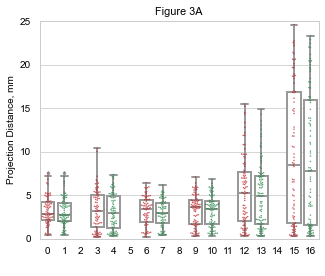

In [5]:
# Figure 3. Projection and inter-electrode distances.
# Figure 3A
plot_projection_distance(plot_dict)

/Users/chantel/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 18.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/chantel/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 9.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/chantel/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 6.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/chantel/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 13.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/chantel/anaconda3/lib/python3.7/site-packages/seaborn/categ

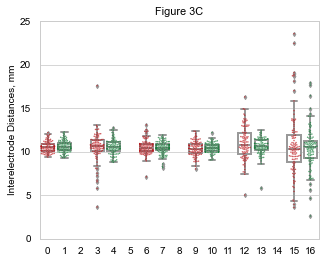

In [105]:
# Figure 3C
plot_interelectrode_distance(plot_dict)

/Users/chantel/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 6.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/chantel/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 14.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


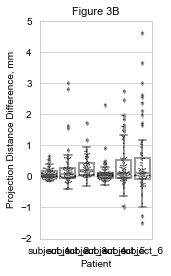

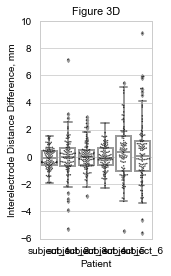

In [106]:
# Figure 3B & Figure 3D
plot_pairwise_distances(plot_dict)

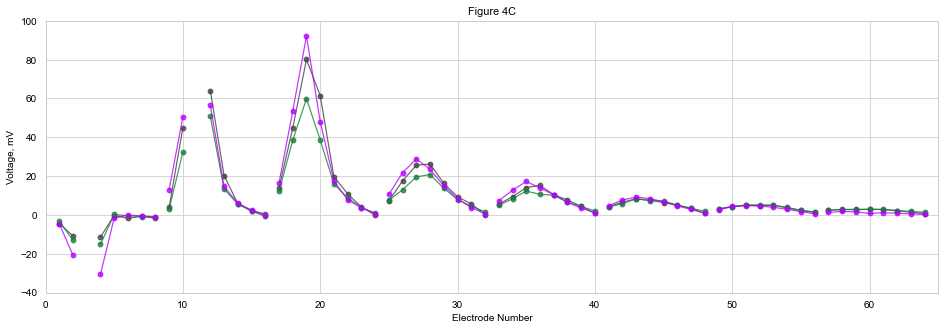

In [107]:
# Figure 4.Voltage and error for patient 3. 
# Figure 4C 
plot_final_voltage_subject(plot_dict['subject_3'],'hermes_0')

/Users/chantel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


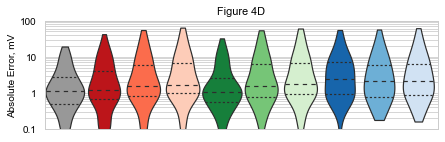

In [108]:
# Figure 4D
voltage_df = create_voltage_df(plot_dict)
df4 = log_absolute_error(voltage_df)
plot_error_all_methods_subject(df4, 'subject_3', rigid=True, error_type='Absolute')

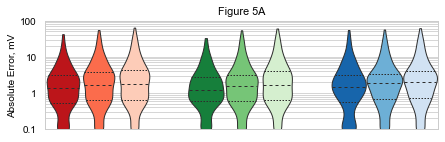

In [109]:
# Figure 5. Absolute errors and linear regression results across patients.
# Figure 5A
plot_error_all_methods(df4, rigid=False, error_type='Absolute')

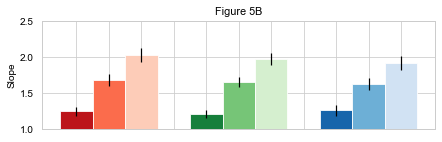

In [121]:
# Figure 5B
plot_predicted_vs_clinical_all(voltage_df)

/Users/chantel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chantel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chantel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chantel/anaconda3/lib/python3.7/site-packages/ipykernel_laun

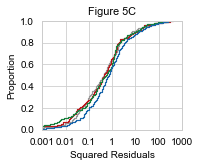

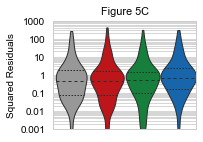

In [130]:
# Figure 5C
# remove subject 5 & 6 (no Dykstra results)
plot_dict_4 = {subject:plot_dict[subject] for subject in ['subject_1','subject_2','subject_3','subject_4']}
voltage_df_4 = create_voltage_df(plot_dict_4)
plot_residuals(voltage_df_4)


/Users/chantel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chantel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chantel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

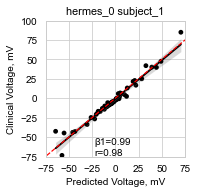

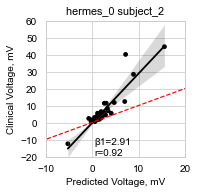

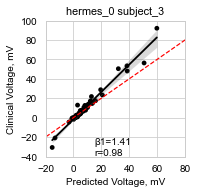

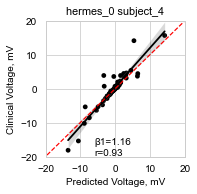

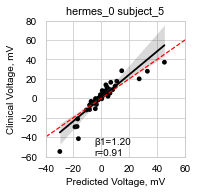

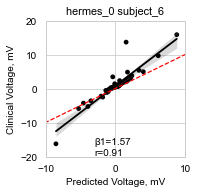

In [134]:
# Figure 6. Predicting the recorded voltage
# Figure 6A
plot_predicted_vs_clinical(plot_dict, ['hermes_0','hermes_0','hermes_0', 'hermes_0', 'hermes_0', 'hermes_0'])

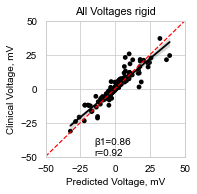

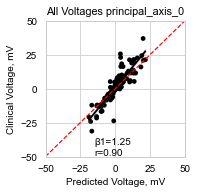

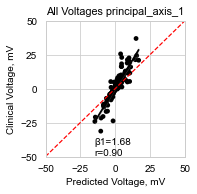

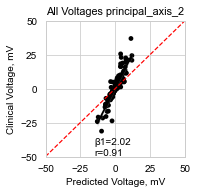

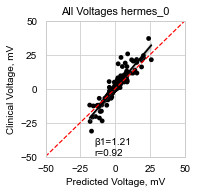

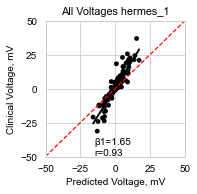

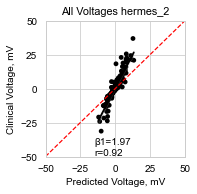

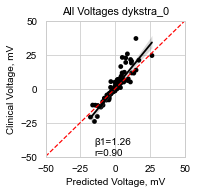

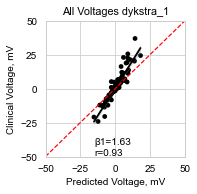

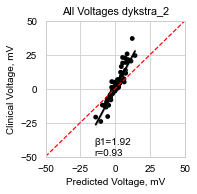

In [145]:
# Figure 6B
plot_predicted_vs_clinical_all_2(voltage_df)

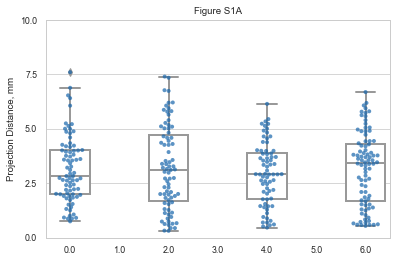

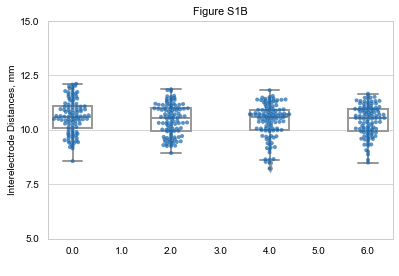

In [151]:
# Supplemental Figures
# Figure S1. Dykstra projection and inter-electrode distances. 
# Figure S1A
plot_projection_dykstra_all_subjects(plot_dict)

#Figure S1B
plot_interelectrode_dykstra_subject(plot_dict)

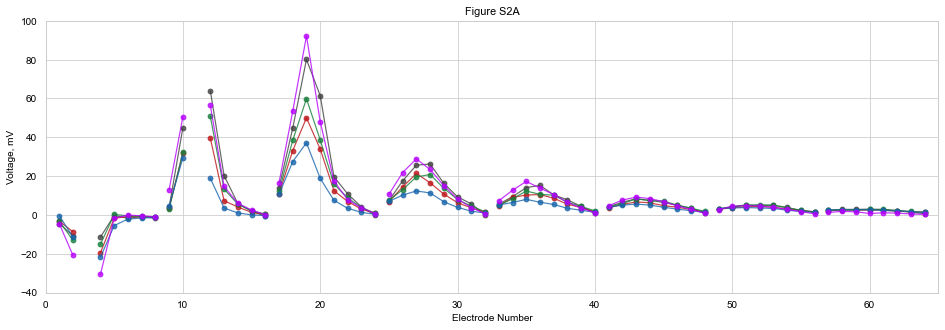

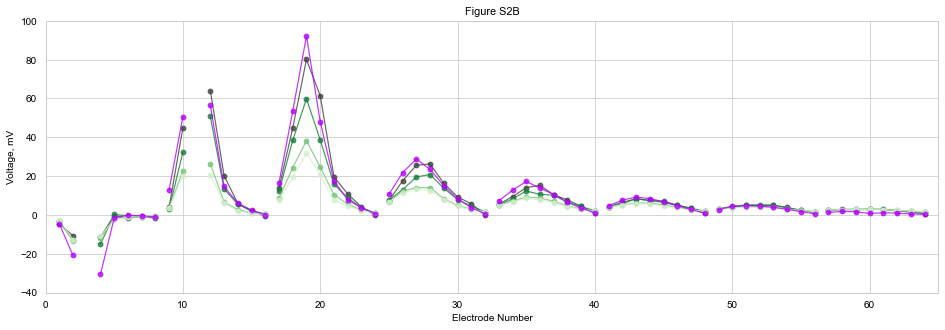

In [149]:
# Figure S2. All voltages for patient 3. 
# Figure S2A
plot_final_voltage_subject_method(plot_dict['subject_3'])

# Figure S2B
plot_final_voltage_subject_csf(plot_dict['subject_3'])